In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import loader, os
import numpy as np

/opt/miniconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Namespace(checkpoint_dir=None, data='foo', data_format='NCHW', depth=50, eps=0.0, eval=False, fake=False, gpu='0,1,2,3,4,5,6,7', image_size=None, load=None, lp=None, mode='resnet')
Epsilon: 0.0


In [2]:
# ckpt is of the form: data/{model directory}
NET = 'l2_adv'

ckpt = os.path.join('data', {
    'l2_adv':'train_224_robust_eps_1.0_lp_2_slim',
    'nat':'train_224_nat_slim',
    'linf_adv':'train_224_robust_eps_0.005_lp_inf_slim'
}[NET])

In [3]:
img_nums = [[int(x.split(' ')[0].split('_')[2][:-5]), (int(x.split(' ')[1]))] for x in open('/scratch/engstrom/robust-resnet/ilsvrc_metadata/val.txt').read().split('\n') if x]
img_nums = np.array(img_nums)

In [4]:
def load_img(k):
    im, _ = loader.load_img(img_nums[k][0])
    la = img_nums[k][1]
    return im, la

In [5]:
img, lab = tf.placeholder(shape=[None, 224, 224, 3], dtype=tf.float32), tf.placeholder(shape=[None], dtype=tf.int32)

In [6]:
sess = tf.InteractiveSession()
logits, xent = loader.get_model(sess, img, lab, ckpt, 224)

[0606 00:36:16 @registry.py:121] conv0 input: [None, 3, 224, 224]
[0606 00:36:16 @registry.py:129] conv0 output: [None, 64, 112, 112]
[0606 00:36:16 @registry.py:121] pool0 input: [None, 64, 112, 112]
[0606 00:36:16 @registry.py:129] pool0 output: [None, 64, 56, 56]
[0606 00:36:16 @registry.py:121] group0/block0/conv1 input: [None, 64, 56, 56]
[0606 00:36:16 @registry.py:129] group0/block0/conv1 output: [None, 64, 56, 56]
[0606 00:36:16 @registry.py:121] group0/block0/conv2 input: [None, 64, 56, 56]
[0606 00:36:16 @registry.py:129] group0/block0/conv2 output: [None, 64, 56, 56]
[0606 00:36:16 @registry.py:121] group0/block0/conv3 input: [None, 64, 56, 56]
[0606 00:36:16 @registry.py:129] group0/block0/conv3 output: [None, 256, 56, 56]
[0606 00:36:16 @registry.py:121] group0/block0/convshortcut input: [None, 64, 56, 56]
[0606 00:36:16 @registry.py:129] group0/block0/convshortcut output: [None, 256, 56, 56]
[0606 00:36:16 @registry.py:121] group0/block1/conv1 input: [None, 256, 56, 56]
[

[0606 00:36:17 @registry.py:121] group3/block0/conv3 input: [None, 512, 7, 7]
[0606 00:36:17 @registry.py:129] group3/block0/conv3 output: [None, 2048, 7, 7]
[0606 00:36:17 @registry.py:121] group3/block0/convshortcut input: [None, 1024, 14, 14]
[0606 00:36:17 @registry.py:129] group3/block0/convshortcut output: [None, 2048, 7, 7]
[0606 00:36:17 @registry.py:121] group3/block1/conv1 input: [None, 2048, 7, 7]
[0606 00:36:17 @registry.py:129] group3/block1/conv1 output: [None, 512, 7, 7]
[0606 00:36:17 @registry.py:121] group3/block1/conv2 input: [None, 512, 7, 7]
[0606 00:36:17 @registry.py:129] group3/block1/conv2 output: [None, 512, 7, 7]
[0606 00:36:17 @registry.py:121] group3/block1/conv3 input: [None, 512, 7, 7]
[0606 00:36:17 @registry.py:129] group3/block1/conv3 output: [None, 2048, 7, 7]
[0606 00:36:17 @registry.py:121] group3/block2/conv1 input: [None, 2048, 7, 7]
[0606 00:36:17 @registry.py:129] group3/block2/conv1 output: [None, 512, 7, 7]
[0606 00:36:17 @registry.py:121] gro

In [7]:
g, = tf.gradients(xent, [img])

In [8]:
def get_top5(x):
    if len(x.shape) == 3:
        x = np.expand_dims(x, 0)

    np_logits = logits.eval(feed_dict={
        img:x,
    })

    np_probs = softmax(np_logits)
    ind = np.argpartition(np_probs[0], -9)[-9:]
    top5 = ind[np.argsort(np_probs[0][ind])[::-1]]

    return list(zip(top5, np_probs[0][top5]))

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=1) # only difference

In [26]:
def get_grad(x, y):
    y = np.array(y)
    if len(x.shape) == 3:
        x = x[None, ...]
    if len(y.shape) == 0:
        y = y[None, ...]

    return g.eval({
        img:x,
        lab:y
    })

def clipper(o, x, eps):
    x = np.clip(x, 0, 1)
    delta = x - o
    n = np.linalg.norm(delta)
    if n <= eps:
        return x
    else:
        return o + (delta)/n * eps
    
def make_adv_l2(im):
    adv = im[None, ...]
    s = 1.5
    eps = 40.0
    for i in range(40):
        g_ = get_grad(adv, la)
        g_ = g_ / np.linalg.norm(g_)
        adv = clipper(im[None,...], adv + g_ * s, eps)

    return adv

In [47]:
def vis_grad(img):
    std = 3 * np.std(img)
    img = np.clip(img, a_max=std, a_min=-std)
    img = (1 + img / std) * 0.5
    plt.imshow(img)

In [10]:
example_imgs = [int(x) for x in open('example_imgs.txt', 'r').read().split('\n') if x]

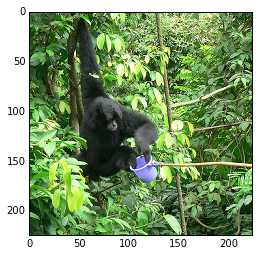

In [39]:
# load image
im, la = load_img(example_imgs[-7])
plt.imshow(im)

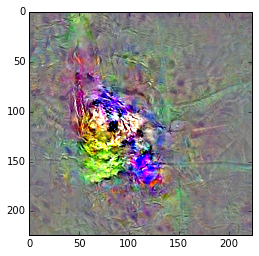

In [49]:
# gradient viz
gg = get_grad(im, la)[0]
vis_grad(gg)

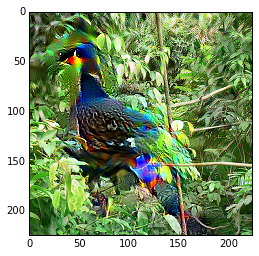

In [50]:
# make adv ex: primate to bird
adv = make_adv_l2(im)[0]
plt.imshow(adv)